### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

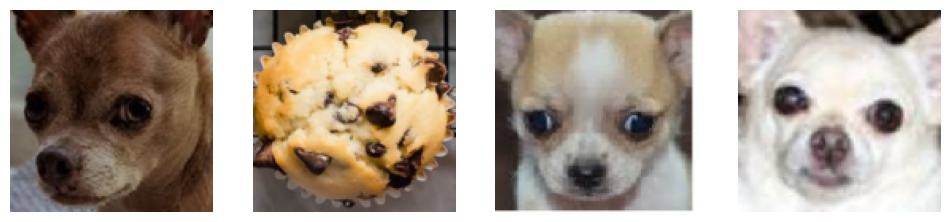

tensor([0, 1, 0, 0])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [9]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [10]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [11]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [12]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [13]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [14]:
X, y = next(train_batches)

#### Make a prediction on the minibatch (Forward pass)

In [15]:
y_hat = model(X)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [16]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)


In [17]:
train_losses

[tensor(6.9078, grad_fn=<DivBackward1>)]

#### Calculate the gradient (Backward pass)

In [18]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [19]:
# Manually update the weights using the gradient descent rule
optimizer.step() # ( parameters - learning rate ) * gradient_of_parameters

# Zero the gradients after updating
model.zero_grad()


#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [20]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010]) tensor([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 0.])


In [21]:
print(train_losses)
print(val_losses)

[tensor(6.9078, grad_fn=<DivBackward1>)]
[38.13664627075195]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

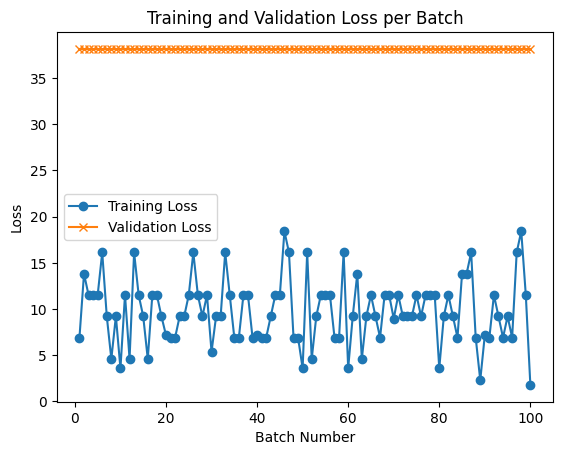

In [22]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [23]:
# Create a neural network with 3 hidden layers as shown in the picture

class ThreeHiddenLayerNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 128 * 3, 64)
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(64, 32)
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(32, 2)

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.relu1(x)
    x = self.linear2(x)
    x = self.relu2(x)
    x = self.linear3(x)
    return x

In [24]:
def train_model(learning_rate, num_epochs):
  # 2. Initialize an instance of ThreeHiddenLayerNet.
  model = ThreeHiddenLayerNet()

  # 3. Define the loss function using nn.CrossEntropyLoss().
  criterion = nn.CrossEntropyLoss()

  # 4. Initialize the optimizer using optim.SGD with model.parameters(), the provided learning_rate, and momentum=0.9.
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  # 5. Reset the model's weights to zero
  with torch.no_grad():
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            layer.weight.zero_()
            if layer.bias is not None:
                layer.bias.zero_()

  # 6. Create two empty lists, epoch_train_losses and epoch_val_losses
  epoch_train_losses = []
  epoch_val_losses = []

  # 7. Implement a training loop that runs for num_epochs
  for epoch in range(num_epochs):
    # a. For each epoch, initialize an empty list batch_train_losses
    batch_train_losses = []

    # b. Iterate through train_loader to get X (inputs) and y (labels) for each training batch
    for X, y in train_loader:
      # i. Perform a forward pass to get predictions y_hat from the model.
      y_hat = model(X)
      # Note: CrossEntropyLoss expects target (y) to be of type LongTensor, not FloatTensor
      # y = y.to(torch.float32) # This was for BCEWithLogitsLoss, not needed for CrossEntropyLoss

      # ii. Calculate the batch training loss
      loss = criterion(y_hat, y)

      # iii. Append the loss.item() to batch_train_losses.
      batch_train_losses.append(loss.item())

      # iv. Perform a backward pass (loss.backward()).
      loss.backward()

      # v. Update model parameters (optimizer.step()).
      optimizer.step()

      # vi. Zero the gradients (model.zero_grad()).
      model.zero_grad()

    # c. Calculate the average training loss for the current epoch
    epoch_train_losses.append(np.mean(batch_train_losses))

    # d. Within a torch.no_grad() context, initialize an empty list batch_val_losses.
    batch_val_losses = []
    with torch.no_grad():
      # e. Iterate through val_loader
      for X_val, y_val in val_loader:
        # i. Perform a forward pass
        y_hat_val = model(X_val)
        # y_val = y_val.to(torch.float32) # Not needed for CrossEntropyLoss

        # ii. Calculate the batch validation loss
        val_loss = criterion(y_hat_val, y_val)

        # iii. Append the loss.item() to batch_val_losses.
        batch_val_losses.append(val_loss.item())

    # f. Calculate the average validation loss for the current epoch
    epoch_val_losses.append(np.mean(batch_val_losses))

  # 8. After the training loop, return epoch_train_losses and epoch_val_losses.
  return epoch_train_losses, epoch_val_losses


In [25]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
num_epochs = 20 # Can be adjusted

results = {}

for lr in learning_rates:
  print(f"Training with learning rate: {lr}")
  train_losses, val_losses = train_model(lr, num_epochs)
  results[lr] = {'train_losses': train_losses, 'val_losses': val_losses}

print("Training complete for all learning rates.")

Training with learning rate: 0.01
Training with learning rate: 0.001
Training with learning rate: 0.0001
Training with learning rate: 1e-05
Training complete for all learning rates.


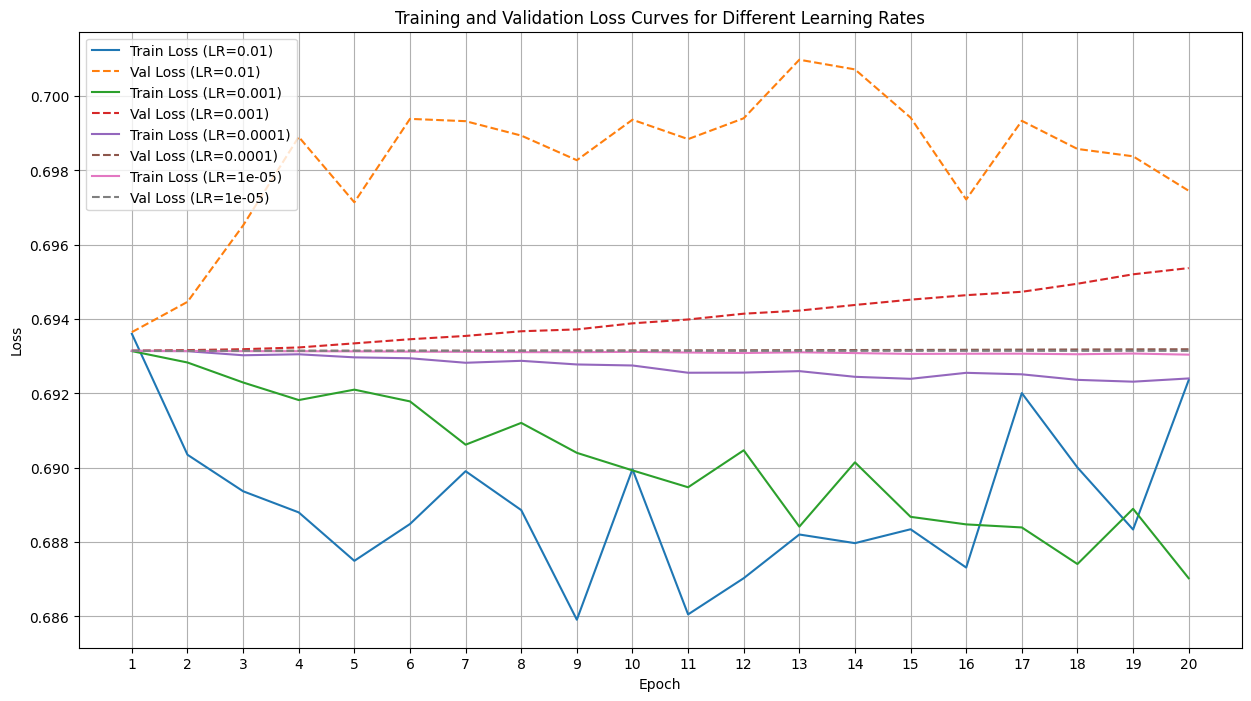

In [26]:
plt.figure(figsize=(15, 8))

for lr, data in results.items():
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, data['train_losses'], label=f'Train Loss (LR={lr})', linestyle='-')
    plt.plot(epochs, data['val_losses'], label=f'Val Loss (LR={lr})', linestyle='--')

plt.title('Training and Validation Loss Curves for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs) # Ensure all epochs are shown on x-axis
plt.legend()
plt.grid(True)
plt.show()


*   **2.1 What value of learning rate do you **think** is the best? Please explain your reason.**
    ค่า learning rate ที่ 0.001 (เส้นสีเขียว) เป็นค่าที่มีประสิทธิภาพที่สุด เนื่องจากทั้งค่า training loss และค่า validation loss แสดงให้เห็นการลดลงที่ชัดเจนและสม่ำเสมอ ซึ่งบ่งชี้ถึงการเรียนรู้ที่มีประสิทธิภาพและการสรุปผลที่ดีโดยไม่มีความไม่เสถียรหรือการหยุดนิ่ง
*   **2.2 What happens to the training losses if your learning rate is too large?**
    หากค่า learning rate (เช่น 0.01) ค่า training loss จะเกิดความไม่เสถียรและมีการแกว่งตัวอย่างมีนัยสำคัญ บางครั้งอาจเพิ่มขึ้นด้วยซ้ำ ความไม่เสถียรนี้เกิดจากการที่ optimizer ก้าวไปข้างหน้ามากเกินไป ซึ่งมักจะข้ามจุดที่เหมาะสมและนำไปสู่การเบี่ยงเบนหรือพฤติกรรมที่ผิดปกติในฟังก์ชันค่าความเสียหาย
*   **2.3 What happens to the training losses if your learning rate is too small?**
    หากอัตราการเรียนรู้มีขนาดเล็กเกินไป (เช่น 0.0001) ค่า training loss จะลดลงช้ามากหรือหยุดนิ่ง โมเดลจะเรียนรู้ในอัตราที่ช้ากว่ามาก ซึ่งหมายความว่าอาจต้องใช้เวลานานมาก (จำนวน epoch ที่มากขึ้น) เพื่อที่จะบรรลุผลลัพธ์ที่ดี



In [27]:
model = ThreeHiddenLayerNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9) # Use the best learning rate identified

# Re-initialize model weights to zero before training
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          if layer.bias is not None:
              layer.bias.zero_()

# Train the model with the best learning rate (1e-3) for the determined number of epochs
train_losses, val_losses = train_model(1e-3, num_epochs)

correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        # Forward pass
        outputs = model(X_test)
        # Get predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')


Accuracy of the model on the test images: 56.67%


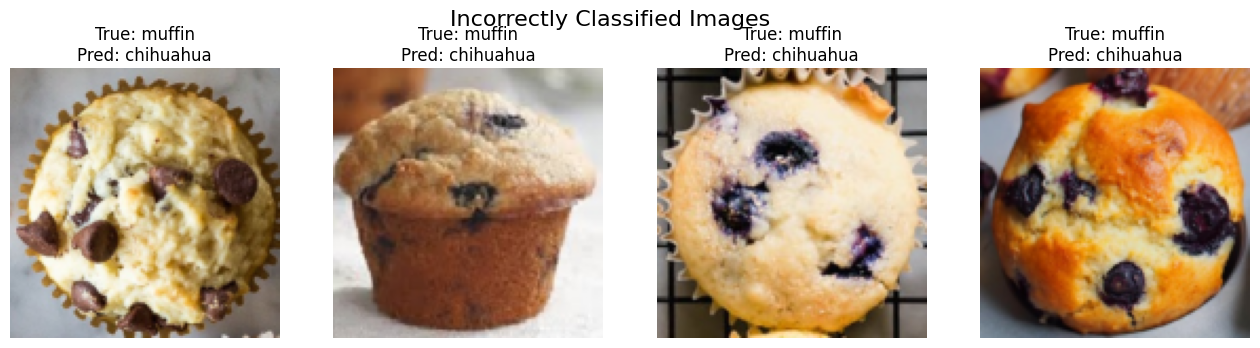

In [28]:
incorrect_images = []
incorrect_labels = []
incorrect_predictions = []

model.eval() # Set the model to evaluation mode
with torch.no_grad():
    for X_test, y_test in test_loader:
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)

        # Identify incorrectly classified samples
        incorrect_indices = (predicted != y_test).nonzero(as_tuple=True)[0]

        for idx in incorrect_indices:
            if len(incorrect_images) < 4: # Collect up to 4 incorrect images
                image = X_test[idx].cpu().numpy().transpose(1, 2, 0) # Convert to (H, W, C) for matplotlib
                incorrect_images.append(image)
                incorrect_labels.append(y_test[idx].item())
                incorrect_predictions.append(predicted[idx].item())
            else:
                break # Stop if we have enough images
    if len(incorrect_images) == 0: # If no incorrect images were found (unlikely but possible)
        print("No incorrectly classified images found.")

# Visualize the incorrectly classified images
if len(incorrect_images) > 0:
    fig, axes = plt.subplots(1, len(incorrect_images), figsize=(4 * len(incorrect_images), 4))
    fig.suptitle('Incorrectly Classified Images', fontsize=16)

    # Map class labels to names for better readability
    class_names = dataset.classes # Assuming dataset.classes has the names ('chihuahua', 'muffin')

    if len(incorrect_images) == 1:
        axes = [axes] # Make it iterable for a single image case

    for i, ax in enumerate(axes):
        ax.imshow(incorrect_images[i])
        ax.set_title(f'True: {class_names[incorrect_labels[i]]}\nPred: {class_names[incorrect_predictions[i]]}')
        ax.axis('off')
    plt.show()
else:
    print("Could not find any incorrectly classified images to display.")
